In [25]:
%matplotlib inline

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 11,9

In [105]:
# Load in the unit cell and create map
unitcell = pd.read_hdf("../Files/unitcell_Shifted.h5","Yields")

display(unitcell)

# Use symmetry to condense the cells
a1 = 0.25+0.0127 
b1 = 0.125+0.0127/2 
b2 = (0.25+0.0127)*(np.cos(30*np.pi/180))
b = np.sqrt(b1*b1 + b2*b2)

num_cells = 100

unitcell_df = pd.DataFrame()


x_shift = []
y_shift = []
aYield = []

for ix, hex_cx in enumerate(np.arange(-num_cells, num_cells+1, 1)):
    if (ix % 10 == 0): print(ix)

    for hex_cy in np.arange(-num_cells, num_cells+1, 1):

        # Vector to center of hexagon from origin
        v_c = [hex_cx*a1 + hex_cy*b1, hex_cy*b2]

        for x, y, Yield in zip(unitcell["x"], unitcell["y"], unitcell["Yield"]):
            x_shift.append(v_c[0] + x)
            y_shift.append(v_c[1] + y)
            aYield.append(Yield)


unitcell_df["x"] = x_shift
unitcell_df["y"] = y_shift
unitcell_df["Yield"] = aYield

# unitcell_df_copy = unitcell_df.copy(deep=True)

# Now append the found values
# display(unitcell_df)


,x,y,Yield
9,-0.129666,-0.079724,1217.000000
10,-0.129666,-0.071946,1210.777778
11,-0.129666,-0.064168,1222.263158
12,-0.129666,-0.056390,1217.625000
13,-0.129666,-0.048612,1221.052632
...,...,...,...
1507,0.126298,0.044723,1230.488889
1508,0.126298,0.052501,1228.272727
1509,0.126298,0.060279,1232.175000
1510,0.126298,0.068057,1227.255319


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [106]:
# unitcell_df = unitcell_df_copy.copy(deep=True)


bmin_x=-(0.125+0.0127/2.0)
bmax_x=(0.125+0.0127/2.0)

numbins = 15

num_cells = 100

bmin_x*=num_cells
bmax_x*=num_cells
numbins*=num_cells-1

bins_x = np.linspace(bmin_x, bmax_x, numbins)
bw_x=(bins_x[1]-bins_x[0])/2.0
bins_centre_x = np.linspace(bmin_x+bw_x/2, bmax_x+bw_x/2, numbins)[:-1]

bmin_y=-(0.125+0.0127/2)/(np.cos(30*np.pi/180))
bmax_y=(0.125+0.0127/2)/(np.cos(30*np.pi/180))

bmin_y*=num_cells
bmax_y*=num_cells

bins_y = np.linspace(bmin_y, bmax_y, numbins)
bw_y=(bins_y[1]-bins_y[0])/2.0
bins_centre_y = np.linspace(bmin_y+bw_y/2, bmax_y+bw_y/2, numbins)[:-1]

# Now bin the data
unitcell_df['x'] = pd.cut(x=unitcell_df['x'], bins=bins_x,labels=bins_centre_x, include_lowest=True)
unitcell_df['y'] = pd.cut(x=unitcell_df['y'], bins=bins_y,labels=bins_centre_y, include_lowest=True)


# Now average over the events
unitcell_df_avg = unitcell_df.groupby(['x', 'y']).mean()
unitcell_df_avg = unitcell_df_avg.fillna(0)
unitcell_df_avg.reset_index(inplace=True) 



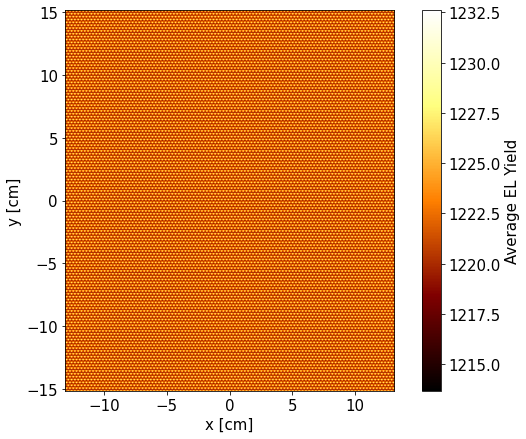

In [107]:

# Plot the map
fig, ax = plt.subplots(figsize =(10, 7))

# Creating plot
h, xedges, yedges = np.histogram2d(unitcell_df_avg["x"], unitcell_df_avg["y"], weights=unitcell_df_avg["Yield"], bins=[bins_x, bins_y])
im = ax.imshow(np.flip(h.T, axis=0), extent=[bins_x[0],bins_x[-1], bins_y[0], bins_y[-1]], cmap="afmhot") #, vmin=-1.5)
cbar = plt.colorbar(im, ax=ax)

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)

ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
cbar.set_label("Average EL Yield")

In [115]:
# Load in the input file
# input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus.next.h5"
input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus_40keV.next.h5"

## True hits (deposited energy)
hits = pd.read_hdf(input_file, 'MC/hits')
hits = hits[hits["label"] == "ACTIVE"]
hits = hits.drop(columns = ["label", "hit_id", "time", "particle_id"])

# Replace nan to zeros
hits['energy'] = hits['energy'].fillna(0)

In [116]:
# Calculate the total energy of each hit
hitsum = hits
hitsum = hitsum.drop(columns = ["x", "y", "z"])
hitsum['Esum'] = hitsum.groupby(["event_id"])["energy"].transform('sum')
hitsum = hitsum.drop(columns = ["energy"])
hitsum = hitsum.drop_duplicates()

# Get a list of events who do not deposit all their energy in the detector
# bad_events = hitsum[hitsum["Esum"] != 2.458].event_id.values

# Filter the main hit list from the bad events
# hits = hits[~hits.event_id.isin(bad_events)]

# Change the units of energy to eV
hits["energy"] = hits["energy"]*1e6
hits["ni"] = hits["energy"]/22.0
hits["ni"] = hits["ni"].round()

# Calculate the diffusion sigma
D_L = 0.38 # mm/cm^0.5
hits["sigma"] = np.sqrt(hits["z"]) * D_L # [mm]
print(hits["sigma"].max())
print(hits["sigma"].min())

print(hits["ni"].sum())

# Drop the energy and z columns
hits = hits.drop(columns = ["z", "energy"])

display(hits)


6.201193332672119
6.1962361335754395
181834.0


,event_id,x,y,ni,sigma
0,0,-0.025970,0.010035,26.0,6.199213
1,0,-0.079138,0.019493,234.0,6.199791
2,0,-0.084094,0.072381,112.0,6.200083
3,0,-0.133365,0.055577,257.0,6.200127
4,0,-0.105219,0.079909,49.0,6.200239
...,...,...,...,...,...
1193,99,0.078306,-0.174279,164.0,6.197922
1194,99,0.074305,-0.180740,184.0,6.197889
1195,99,0.075112,-0.178464,28.0,6.197918
1196,99,0.074377,-0.180430,206.0,6.197941


In [117]:
rng = np.random.default_rng()

evid = -1

Yieldsum = 0

Yields = []

for ev,x,y,ni,sigma in zip(hits["event_id"], hits["x"], hits["y"], hits["ni"], hits["sigma"]):

    temp_df = pd.DataFrame()

    if (evid != ev):

        if (Yieldsum != 0):
            print("Yield: ",Yieldsum)
            Yields.append(Yieldsum)

        Yieldsum = 0
        evid = ev

        # if(ev % 10 == 0):
        print(ev)
    
    # Calculate smeared position for each electron
    mean = (x, y)
    cov = [[sigma, 0], [0, sigma]]
    x_samp, y_samp = rng.multivariate_normal(mean, cov, int(ni)).T

    # Create a dataframe and bin the x and y sample
    temp_df["x"] = x_samp
    temp_df["y"] = y_samp

    if (temp_df['x'].values.max() >  max(bins_x) or temp_df['x'].values.min() <  min(bins_x)):
        print("Error hit sample is out of range...")

    temp_df["x"] = pd.cut(x=temp_df['x'], bins=bins_x,labels=bins_centre_x, include_lowest=True)
    temp_df["y"] = pd.cut(x=temp_df['y'], bins=bins_y,labels=bins_centre_y, include_lowest=True)
    
    Yieldsum += pd.merge(temp_df, unitcell_df_avg, how ='inner', on =['x', 'y']).Yield.sum()
    # print(Yieldsum)



0
Yield:  2223675.0478124325
1
Yield:  2223091.794693564
2
Yield:  2221973.988431311
3
Yield:  2224543.0499753053
4
Yield:  2223391.9606344863
5
Yield:  2222126.786660341
6
Yield:  2222199.6488446277
7
Yield:  2221880.9637645227
8
Yield:  2223206.2502610534
9
Yield:  2220896.801884288
10
Yield:  2223279.3666236345
11
Yield:  2222030.9744690703
12
Yield:  2222043.606993556
13
Yield:  2220820.9810282197
14
Yield:  2223304.091225687
15
Yield:  2222276.391940943
16
Yield:  2223229.711853033
17
Yield:  2221061.000136445
18
Yield:  2220753.9489092114
19
Yield:  2224447.760737534
20
Yield:  2223182.0421529547
21
Yield:  2223420.5573495724
22
Yield:  2223642.599203232
23
Yield:  2222312.170903914
24
Yield:  2223611.3026421433
25
Yield:  2222048.5678929235
26
Yield:  2223215.6257198006
27
Yield:  2223374.072198108
28
Yield:  2224735.0438259835
29
Yield:  2221043.0735371015
30
Yield:  2223567.9285305813
31
Yield:  2223422.0878129117
32
Yield:  2223246.2395047904
33
Yield:  2221070.1613506936
34


[1.73964927e+00 2.22258782e+00 1.22949027e-03]
Resolution =  0.1302737987476262


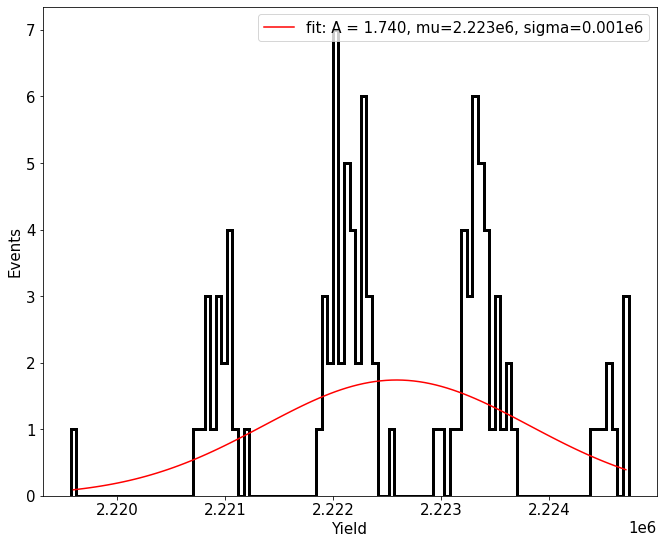

In [118]:
# Make a histogram of the total photon yeilds
plt.figure()
counts, xbins, _ = plt.hist(Yields, bins = 100, histtype="step", color = "black", linewidth=3)
# plt.xlim(-200, 6200)
plt.xlabel("Yield")
plt.ylabel("Events")

xbins/=1e6

# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
bin_centers = bin_centers[:-1]

popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds = ([0, 0.8, 0], [600, 4.0, 0.5]))
print(popt)

plt.plot(bin_centers*1e6, Gaussian_(bin_centers, *popt), 'r-',label='fit: A = %5.3f, mu=%5.3fe6, sigma=%5.3fe6' % tuple(popt))
print("Resolution = ",100* 2.355*popt[2]/popt[1] )
plt.legend()
plt.show()
